# Happy or Sad Image Classifier

<table>
<tr>
<td><img src="./data/train/happy_face/smile.jpg" height="224px" width="224px"></td>
<td><img src="./data/train/sad_face/crying.jpg" height="204px" width="224px"></td>
</tr>
<tr>
<td> <h3 align="center">Label: Happy </h3> </td>
<td> <h3 align="center">Label: sad </h3></td>
</tr>
</table>

In [1]:
#Step 1: Use Pretrained VGG16 network and extract the features.

from keras.applications import VGG16,imagenet_utils
from keras.preprocessing.image import load_img,img_to_array
import numpy as np
from keras.models import Model
preprocess = imagenet_utils.preprocess_input
model = VGG16(weights="imagenet")
new_model = Model(inputs=model.input,outputs=model.layers[21].output)

def convert_img_to_vector(img_path):
    image = load_img(img_path,target_size=(224,224))
    image = img_to_array(image)
    image = np.expand_dims(image,axis=0)
    image = preprocess(image)
    return image

def get_image_feature(img_path):
    feats = np.transpose(new_model.predict(convert_img_to_vector(img_path)))
    return feats

Using TensorFlow backend.


In [2]:
#2. Import the custom dataset and compute the top 4096 features.
import glob
train_happy = glob.glob('./data/train/happy_face/*')
train_sad = glob.glob('./data/train/sad_face/*')

total_train = len(train_happy) + len(train_sad)

val_happy = glob.glob('./data/validation/happy_face/*')
val_sad = glob.glob('./data/validation/sad_face/*')

total_val = len(val_happy) + len(val_sad)

feats_train_happy = np.array([[get_image_feature(filename)] for filename in train_happy])
feats_train_sad = np.array([[get_image_feature(filename)] for filename in train_sad])
feats_train = np.hstack([feats_train_happy,feats_train_sad]).reshape(-1,4096)
del feats_train_happy,feats_train_sad  #we dont require

feats_val_happy = np.array([[get_image_feature(filename)] for filename in val_happy])
feats_val_sad = np.array([[get_image_feature(filename)] for filename in val_sad])
feats_val = np.hstack([feats_val_happy,feats_val_sad]).reshape(-1,4096)
del feats_val_happy,feats_val_sad #we dont require
print(feats_train.shape,feats_val.shape)

(348, 4096) (16, 4096)


In [4]:
#3. Define out model.
from keras.optimizers import rmsprop
from keras.models import Sequential
from keras.layers import Dropout,Flatten,Dense
model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(4096,), kernel_initializer="normal"))
model.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))
opt = rmsprop(lr=0.0001, decay=1e-6)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [5]:
#4. Defining our Output label.
train_labels = np.array([[0]*174 + [1] * 174]).reshape(-1,1)  #174 happy image, sad image for training respectively
validation_labels = np.array([[0] * 8 + [1] * 8]).reshape(-1,1) #8 validation happy image and sad image.
print(train_labels.shape,validation_labels.shape)

(348, 1) (16, 1)


In [6]:
#5.train our model
model.fit(feats_train,train_labels,epochs=10,batch_size=16,validation_data=(feats_val,validation_labels),verbose=1)
print('Training Completed!')

Train on 348 samples, validate on 16 samples
Epoch 1/10
348/348 [==============================] - 0s - loss: 0.8608 - acc: 0.4856 - val_loss: 0.8842 - val_acc: 0.6250
Epoch 2/10
348/348 [==============================] - 0s - loss: 0.5874 - acc: 0.7011 - val_loss: 0.8192 - val_acc: 0.6250
Epoch 3/10
348/348 [==============================] - 0s - loss: 0.4705 - acc: 0.7701 - val_loss: 0.8702 - val_acc: 0.6250
Epoch 4/10
348/348 [==============================] - 0s - loss: 0.3836 - acc: 0.8534 - val_loss: 0.9156 - val_acc: 0.6250
Epoch 5/10
348/348 [==============================] - 0s - loss: 0.3251 - acc: 0.8851 - val_loss: 1.0280 - val_acc: 0.5000
Epoch 6/10
348/348 [==============================] - 0s - loss: 0.2783 - acc: 0.9282 - val_loss: 1.0745 - val_acc: 0.6250
Epoch 7/10
348/348 [==============================] - 0s - loss: 0.2305 - acc: 0.9425 - val_loss: 1.0739 - val_acc: 0.6250
Epoch 8/10
348/348 [==============================] - 0s - loss: 0.2191 - acc: 0.9397 - val_lo

In [7]:
#6. finding out the optimal threshold.
from sklearn.metrics import roc_curve
import pandas as pd
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
predicted = np.array([model.predict_proba(feats.reshape(-1,4096),verbose=0).reshape(1)[0] for feats in feats_val]).reshape(-1,1)
threshold = Find_Optimal_Cutoff(validation_labels,predicted)[0]

In [8]:
#7. Writing our main predict function

def predict_mood(img_path):
    feats = get_image_feature(img_path)
    feats = feats.reshape(-1,4096)
    predicted_probab = model.predict_proba(feats,verbose=0)
    if predicted_probab > threshold:
        return 'Sad'
    else:
        return 'Happy'

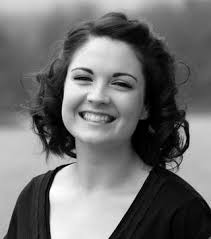

In [9]:
from IPython.display import Image
Image(filename='./data/validation/happy_face/happy_woman.jpg')

In [11]:
predict_mood('./data/validation/happy_face/happy_woman.jpg')

'Happy'

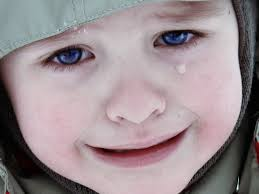

In [12]:
from IPython.display import Image
Image(filename='./data/validation/sad_face/crying_baby.jpg')

In [13]:
predict_mood('./data/validation/sad_face/crying_baby.jpg')

'Sad'